# Tutorial 1: Deriving Lognormal statistics from measurements
This tutorial shows how to derive parameters of the Lognormal distribution using the Method of Moments, and by doing statistics on the logarithm of the values $ln(x)$. The tutorial covers the calculation of characteristic values, inclusing statistical uncertainty and (spatial) averaging. The following steps are discussed:
1. Importing the dataset, interpreting the data
2. Determine the sample mean and standard deviation
3. Determine the Lognormal distribution parameter using the Method of Moments
4. Determine the characteristic values
5. Determine the inputs for D-Stability, taking into account the statistical uncertainty

# Step 1: Importing the dataset, and interpreting the data.
In the next cells, we import the python packages necessary to run this tutorial. If the packages are not available, install them in your Python environment using `pip install <package_name> `

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Import the data using the Pandas package, and show the first 5 entries of the dataframe with the measurements

In [2]:
# The headers are automatically taken as column names.
df = pd.read_csv("input_volumetricweight_testresults.txt", sep=",")
df

,VolWeight
0,17.17
1,18.16
2,19.05
3,17.50
4,17.57
5,20.26
6,18.64
7,18.35
8,17.18
9,15.58


Get our measurements in a numpy array `x`, and plot the histogram of the data.

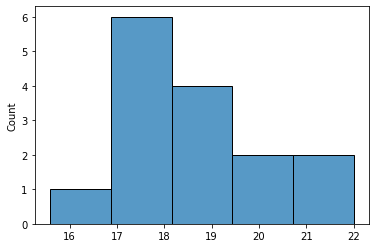

In [3]:
x = df['VolWeight'].to_numpy()
sns.histplot(x, bins=5)
plt.show()

## Step 2: Sample mean and sample standard deviation of the data set

#### Step 2a: Calculate the mean and standard deviation of the 'real' values

In [4]:
# First set up a function to calculate.
def calculate_mean_and_std(x):
    sample_mean = np.mean(x)
    sample_std = np.std(x, ddof=1)
    cov = sample_std/sample_mean

    print('Sample mean = \t\t\t%0.2f'%(sample_mean))
    print('Sample std = \t\t\t%0.3f'%(sample_std))
    print('Coefficient of variation cov = \t%0.3f'%(cov))
    
    return sample_mean, sample_std

# Now calculate the mean and std with that function
print('Mean and standard deviation of x')
mu, sigma = calculate_mean_and_std(x)

Mean and standard deviation of x
Sample mean = 			18.46
Sample std = 			1.701
Coefficient of variation cov = 	0.092


#### Step 2b: Calculate the mean and standard deviation of the logarithmic values

In [5]:
# Here we do almost exactly the same, however, we 
# calculate the mean and std of log(x) 
print('Mean and standard deviation of ln(x)')
m, s = calculate_mean_and_std( np.log(x) )

Mean and standard deviation of ln(x)
Sample mean = 			2.91
Sample std = 			0.090
Coefficient of variation cov = 	0.031


## Step 3: Fitted Lognormal Distribution using method of moments (MoM)

First we introduce two functions. 

1. The first `lognormal_parameters_from_mu_sigma(mu_x, sigma_x, shift)` transforms the mean and standard deviation of x (i.e. the first and second moment, respectively) into the parameters of the Lognormal distribution.
2. The second `mu_sigma_from_lognormal_parameters(mu_y, sigma_y, shift)` does the exact opposite: it transforms the parameters of the Lognormal distribution into the mean and standard deviation of x.

In [6]:
def lognormal_parameters_from_mu_sigma(mu, sigma, shift=0):
    """
    Convention: a Lognormal distribution of X, 
    means that Y = ln(X) is normally distributed. 
    INPUT
        mu = mean(X)
        sigma = std(X)
        shift = default 0
    OUTPUT
        m = mean(Y)
        s = stdev(Y)
        shift 
    """
    m = np.log( (mu - shift)**2 / np.sqrt(sigma**2 + (mu - shift)**2) )
    s = np.sqrt( np.log(sigma**2 / (mu - shift)**2 + 1))
    return m, s, shift

def mu_sigma_from_lognormal_parameters(m,s,shift=0):
    """
    Convention: a Lognormal distribution of X, 
    means that Y = ln(X) is normally distributed. 
    INPUT
        m = mean(Y)
        s = std(Y)
        shift = default 0
    OUTPUT
        mu = mean(X)
        sigma = std(X)
        shift = default 0 
    """
    mu = np.exp(m + s**2 / 2) + shift
    sigma = np.sqrt((mu - shift)**2 * (np.exp(s**2) - 1))
    return mu, sigma, shift

To transform the mean and standard deviation (the first and second moment, respectively) into the parameters of the Lognormal distribution, we call the function. Then we print the result.

In [7]:
# Assume the lognormal is not shifted (shift=0)
shift=0
m, s, shift = lognormal_parameters_from_mu_sigma(mu, sigma, shift)
print('Location, scale, and shift parameters of the\
Lognormal distribution (Y=log(X)) are: \n\
m_Y = \t\t%0.2f\n\
s_Y = \t\t%0.3f\n\
shift_Y =\t%0.1f '%(m,s,shift))

Location, scale, and shift parameters of theLognormal distribution (Y=log(X)) are: 
m_Y = 		2.91
s_Y = 		0.092
shift_Y =	0.0 


The next step is to check the other formula for 'the other way around' (parameters of the Lognormal distribution -> mean and standard deviation).

In [8]:
# Assume the lognormal is not shifted (shift=0)
shift=0
mu, sigma, shift = mu_sigma_from_lognormal_parameters(m,s,shift)
print('Mean, standard deviation, and shift parameters of the\
Lognormal distribution are:\n\
mu_X = \t\t%0.2f\n\
sigma_X = \t%0.3f\n\
shift_X =\t%0.1f \n'%(mu,sigma,shift))

Mean, standard deviation, and shift parameters of theLognormal distribution are:
mu_X = 		18.46
sigma_X = 	1.701
shift_X =	0.0 



### Step 3c: Visual inspection of the results
Now we can visulize the results. We first set up two functions for drawing the pdf of a normal and a lognormal. Then we call this function to make the plots we want.

In [9]:
# First set up 
def plot_pdf_normal(ax, x_range, mu, sigma):
    '''
    Calculate the pdf values using the norm.pdf function.
    Note that python uses the following terminology:
      location (loc) = mean value
      scale (scale) = standard deviation
    '''
    pdf_values = stats.norm.pdf(x_range, loc=mu, scale=sigma)
    ax.plot(x_range, pdf_values, label='PDF normal distribution')
    ax.set_label('Probability density (pdf)')
    
def plot_pdf_lognormal(ax, x_range, m, s, shift=0, label=''):
    '''
    Calculate the pdf values using the lognorm.pdf function.
    Note that python uses the following terminology:
      loc (location) = shift
      scale (scale) = median value (where cdf=0.5 ) -> exp(m)
      s (standard deviation) = s
    '''
    pdf_values = stats.lognorm.pdf(x_range, s=s, loc=shift, scale=np.exp(m))
    ax.plot(x_range, pdf_values, label='PDF lognormal distribution '+label)
    ax.set_label('Probability density (pdf)')
    ax.set_ylim(0)
    ax.legend(loc=1)

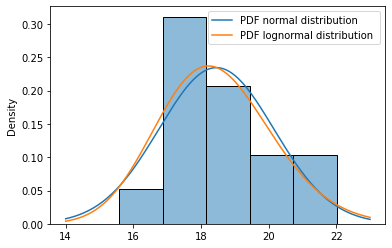

In [10]:
# Plotting the histogram of the data 
ax = sns.histplot(df, bins=5, stat='density')

# Set up an x range for plotting
x_range = np.linspace(14,23,200)

# Plot the pdf of the normal and lognormal distribution for 
# the xrange, using the above function.
plot_pdf_normal(ax, x_range, mu, sigma)
plot_pdf_lognormal(ax, x_range, m, s)

#### Optional step 3d: Derive parameters for a shifted Lognormal distribution, with all values shifted to 14
Note: this is an advanced step to show how a (manually shifted) lognormal distribution could be derived. To this end, we first shift all our data points 'to the left' with a value of 14 (assuming 14 is some kind of physical lower limit for this parameter). Then we derive the statistics for the lognormal parameter, and parse the shift=14 parameter to the plots. 

Sample mean = 			1.42
Sample std = 			0.401
Coefficient of variation cov = 	0.282


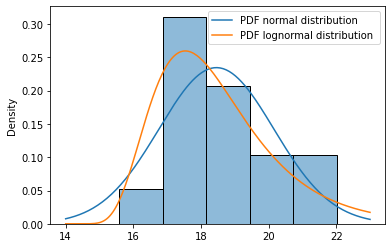

In [11]:
# We assume 14 is a physical lower limit for our volumetric weight parameter
shift = 14
# Shift our measurements and derive the lognormal statistics. 
m_, s_ = calculate_mean_and_std( np.log(x - shift) )

# Plot the histogram and the pdf of a shifted Lognormal distribution
ax = sns.histplot(df, bins=5, stat='density')
plot_pdf_normal(ax, x_range, mu, sigma)
plot_pdf_lognormal(ax, x_range, m_, s_, shift)

## Step 4: Characteristic values

#### Step 4a: Calculate the characteristic value with the Student-T factor.
The number of measurements influences the statistical uncertainty of our estimated mean and standard deviation.
Therefore we apply the Student-T factor to account for statistical uncertainty due to a small number of samples. The characteristic value is calculated as follows:

$X_{char.,5\%} = \exp( m + t_{5\%,n-1} \cdot s \cdot \sqrt{ 1+ 1/n)}$ with $m$ and $s$ the lognormal parameters $\mu_Y$ and $\sigma_Y$.

In [12]:
n = len(df)
student_t_factor = stats.t.ppf(0.05, df=n-1) # df = degrees of freedom, which is n-1
print('t-value \t\t%0.2f'%(student_t_factor))

# The 5%-characteristic value, using the t distributions, including
# the statistical uncertainty in the estimated mean (s/sqrt(n))
# Note the + sign before the student_t_factor, because student_t_factor is negative
characteristic_value = np.exp(m + student_t_factor * s * np.sqrt( 1 + 1 / n ) )
print("5p-char_value = \t%0.2f"%(characteristic_value))

t-value 		-1.76
5p-char_value = 	15.55


#### Step 4b: Calculate the characteristic value with and without spatial avaraging
To account for spatial averaging the $\Gamma^2$ (variance reduction) factor is introduced into the equation

$X_{char.,5\%} = \exp( m + t_{5\%,n-1} \cdot s \cdot \sqrt{ \Gamma^2+ 1/n)}$ with $m$ and $s$ the lognormal parameters $\mu_Y$ and $\sigma_Y$.

Default assumptions on this factor are:
- $\Gamma^2 = 1.0$ : point values, no spatial averaging
- $\Gamma^2 = 0.25$ : estimate of the regional variability, assumption half of the variance averages.
- $\Gamma^2 = 0.0$ : spatial average, full spatial avaraging



In [13]:
# Allocate a list to store multiple outcomes
stored_values = []

# Calculate the characteristic value for different choises of spatial averaging:
gamma2_values = [1.0, 0.25, 0.0];
for gamma2 in gamma2_values: 
    characteristic_value = np.exp(m + student_t_factor * s * np.sqrt( gamma2 + 1 / n ) )
    print("gamma2: 5p-char_value = \t%0.2f"%(characteristic_value))
    stored_values.append(characteristic_value)

gamma2: 5p-char_value = 	15.55
gamma2: 5p-char_value = 	16.78
gamma2: 5p-char_value = 	17.63


#### Step 4c: Visually checking the results

The results are visually checked with the histogram and the pdf's, showing the calculated characteristic value for the different asssumptions with a black vertical line and a colored dot.

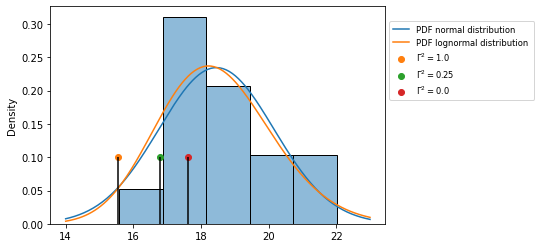

In [14]:
ax = sns.histplot(df, bins=5, stat='density')
plot_pdf_normal(ax, x_range, mu, sigma)
plot_pdf_lognormal(ax, x_range, m, s)

for gamma2, value in zip( gamma2_values, stored_values):
    plt.vlines(value, ymin=0, ymax= 0.1, color='k')
    plt.scatter(value, 0.10, label="$\Gamma ^{2}=%s$"%(gamma2) )
    
plt.legend(fontsize='small', bbox_to_anchor=(1,0.95))
plt.show()

## Step 5: Get the inputs for D-Stability, taking into account the statistical uncertainty
To correct the Lornormal standard deviation for the statistical uncertainty, we increase the std with a factor. 

This factor equals $t_{5\%,n-1}/z_{5\%}$, where $z_{5\%}=-1.645$. 

#### Step 5a: For the uncertainty in the point values

In [15]:
correction_factor = student_t_factor / -1.645 
s_point_incl_stat =  s * correction_factor * np.sqrt(1 + 1 / n)

mu, sigma, shift = mu_sigma_from_lognormal_parameters(m,
                                                      s_point_incl_stat,
                                                      shift=0)
print('Mean, standard deviation, and shift parameters of the\
Lognormal distribution \n\
For D-Stability input:\n\
mu_X = \t\t%0.2f\n\
sigma_X = \t%0.3f\n\
shift_X =\t%0.1f \n'%(mu,sigma,shift))

Mean, standard deviation, and shift parameters of theLognormal distribution 
For D-Stability input:
mu_X = 		18.47
sigma_X = 	1.883
shift_X =	0.0 



#### Step 5b: For the uncertainty in the regional average

In [16]:
s_regional_average_incl_stat =  s * correction_factor * np.sqrt(0.25 + 1 / n)

mu, sigma, shift = mu_sigma_from_lognormal_parameters(m,
                                                      s_regional_average_incl_stat,
                                                      shift=0)
print('Mean, standard deviation, and shift parameters of the\
Lognormal distribution \n\
For D-Stability input:\n\
mu_X = \t\t%0.2f\n\
sigma_X = \t%0.3f\n\
shift_X =\t%0.1f \n'%(mu,sigma,shift))

Mean, standard deviation, and shift parameters of theLognormal distribution 
For D-Stability input:
mu_X = 		18.41
sigma_X = 	1.021
shift_X =	0.0 



#### Step 5c: For the uncertainty in the spatial average

In [17]:
s_spatial_average_incl_stat =  s * correction_factor * np.sqrt(1 / n)

mu, sigma, shift = mu_sigma_from_lognormal_parameters(m,
                                                      s_spatial_average_incl_stat,
                                                      shift=0)
print('Mean, standard deviation, and shift parameters of the\
Lognormal distribution \n\
For D-Stability input:\n\
mu_X = \t\t%0.2f\n\
sigma_X = \t%0.3f\n\
shift_X =\t%0.1f \n'%(mu,sigma,shift))

Mean, standard deviation, and shift parameters of theLognormal distribution 
For D-Stability input:
mu_X = 		18.39
sigma_X = 	0.467
shift_X =	0.0 



#### Step 5d: Visualize the results

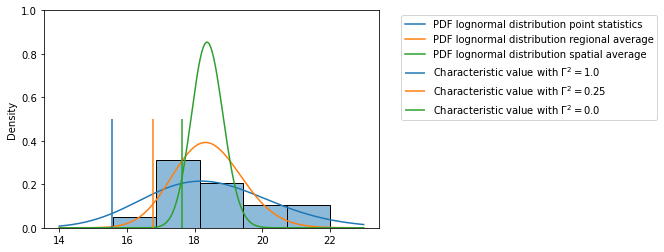

In [18]:
ax = sns.histplot(df, bins=5, stat='density')
plot_pdf_lognormal(ax, x_range, m, s_point_incl_stat, 
                   label='point statistics')
plot_pdf_lognormal(ax, x_range, m, s_regional_average_incl_stat, 
                   label='regional average')
plot_pdf_lognormal(ax, x_range, m, s_spatial_average_incl_stat, 
                   label='spatial average')

colors=['tab:blue', 'tab:orange', 'tab:green']
for i, (gamma2, value) in enumerate(zip( gamma2_values, stored_values)):
    plt.vlines(value, ymin=0, ymax=0.5, color=colors[i], label="Characteristic value with $\Gamma ^{2}=%s$"%(gamma2) )
plt.legend(bbox_to_anchor=(1.05,1))
plt.ylim([0,1])
plt.show()